In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
from numpy.linalg import inv
import statsmodels.api as sm
import pandas as pd
import re
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('/Users/tiziana/Desktop/PYTHON/TESI MAGISTRALE/PCA/DATESET.csv')
df=df.iloc[:, 1:]
df.head()


df.set_index(['Country'],inplace=True)
gre = pd.DataFrame(df.loc['Netherlands'])



gre.reset_index(inplace=True)
gre=gre.drop(['Country','Trimestre'],axis=1)

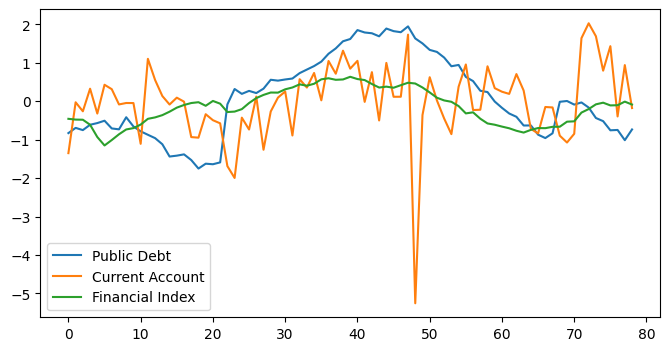

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 4))
plt.plot(gre['Public Debt'], label='Public Debt')
plt.plot(gre['Current Account'], label='Current Account')
plt.plot(gre['Financial index'], label='Financial Index')


plt.legend()

In [4]:
gre['Gdp growth']=gre['Gdp growth']
gre['Current Account'] = gre['Current Account'].diff(1)
gre['Public Debt'] = gre['Public Debt'].diff(1)
gre['Financial index'] = gre['Financial index'].diff(1)

gre=gre.iloc[1:]

In [5]:
from statsmodels.tsa.api import VAR
model = VAR(gre)
lag_order = model.select_order(maxlags=8)  
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,-6.779,-6.650*,0.001138,-6.728
1,-7.027*,-6.384,0.0008886*,-6.772*
2,-6.974,-5.817,0.0009415,-6.514
3,-6.904,-5.233,0.001022,-6.240
4,-6.777,-4.593,0.001186,-5.909
5,-6.530,-3.832,0.001574,-5.458
6,-6.451,-3.239,0.001802,-5.175
7,-6.373,-2.647,0.002110,-4.893
8,-6.345,-2.105,0.002426,-4.661


In [6]:
gre= gre.reindex(columns=['Financial index','Gdp growth','Current Account','Public Debt'])

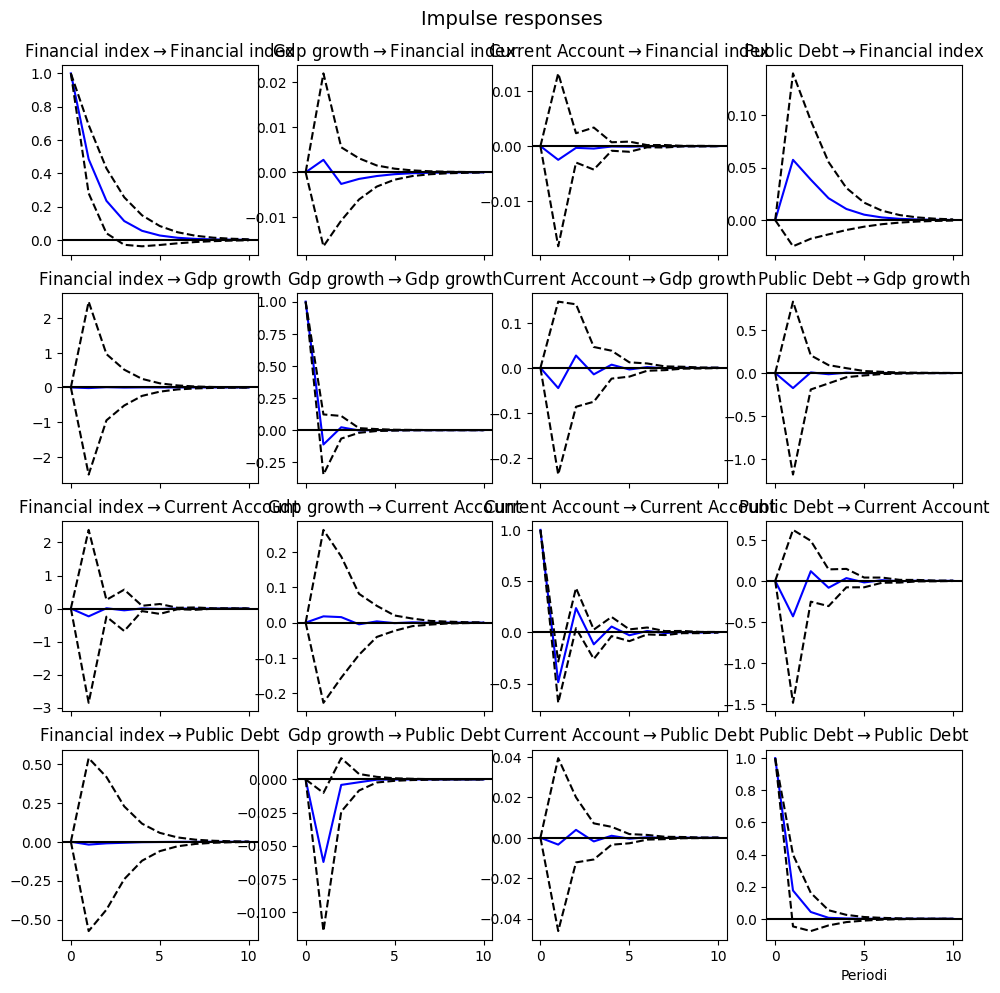

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: fail to reject at 5% significance level. Test statistic: 127.948, critical value: 173.004>, p-value: 0.827>


In [7]:
model = sm.tsa.VAR(gre)

# Stima il modello con un ordine di 1
results = model.fit(1)
irf = results.irf(10)

irf.plot(orth=False)
plt.xlabel('Periodi')

plt.show()
whiteness_test_result = results.test_whiteness(nlags=10)
print(whiteness_test_result)

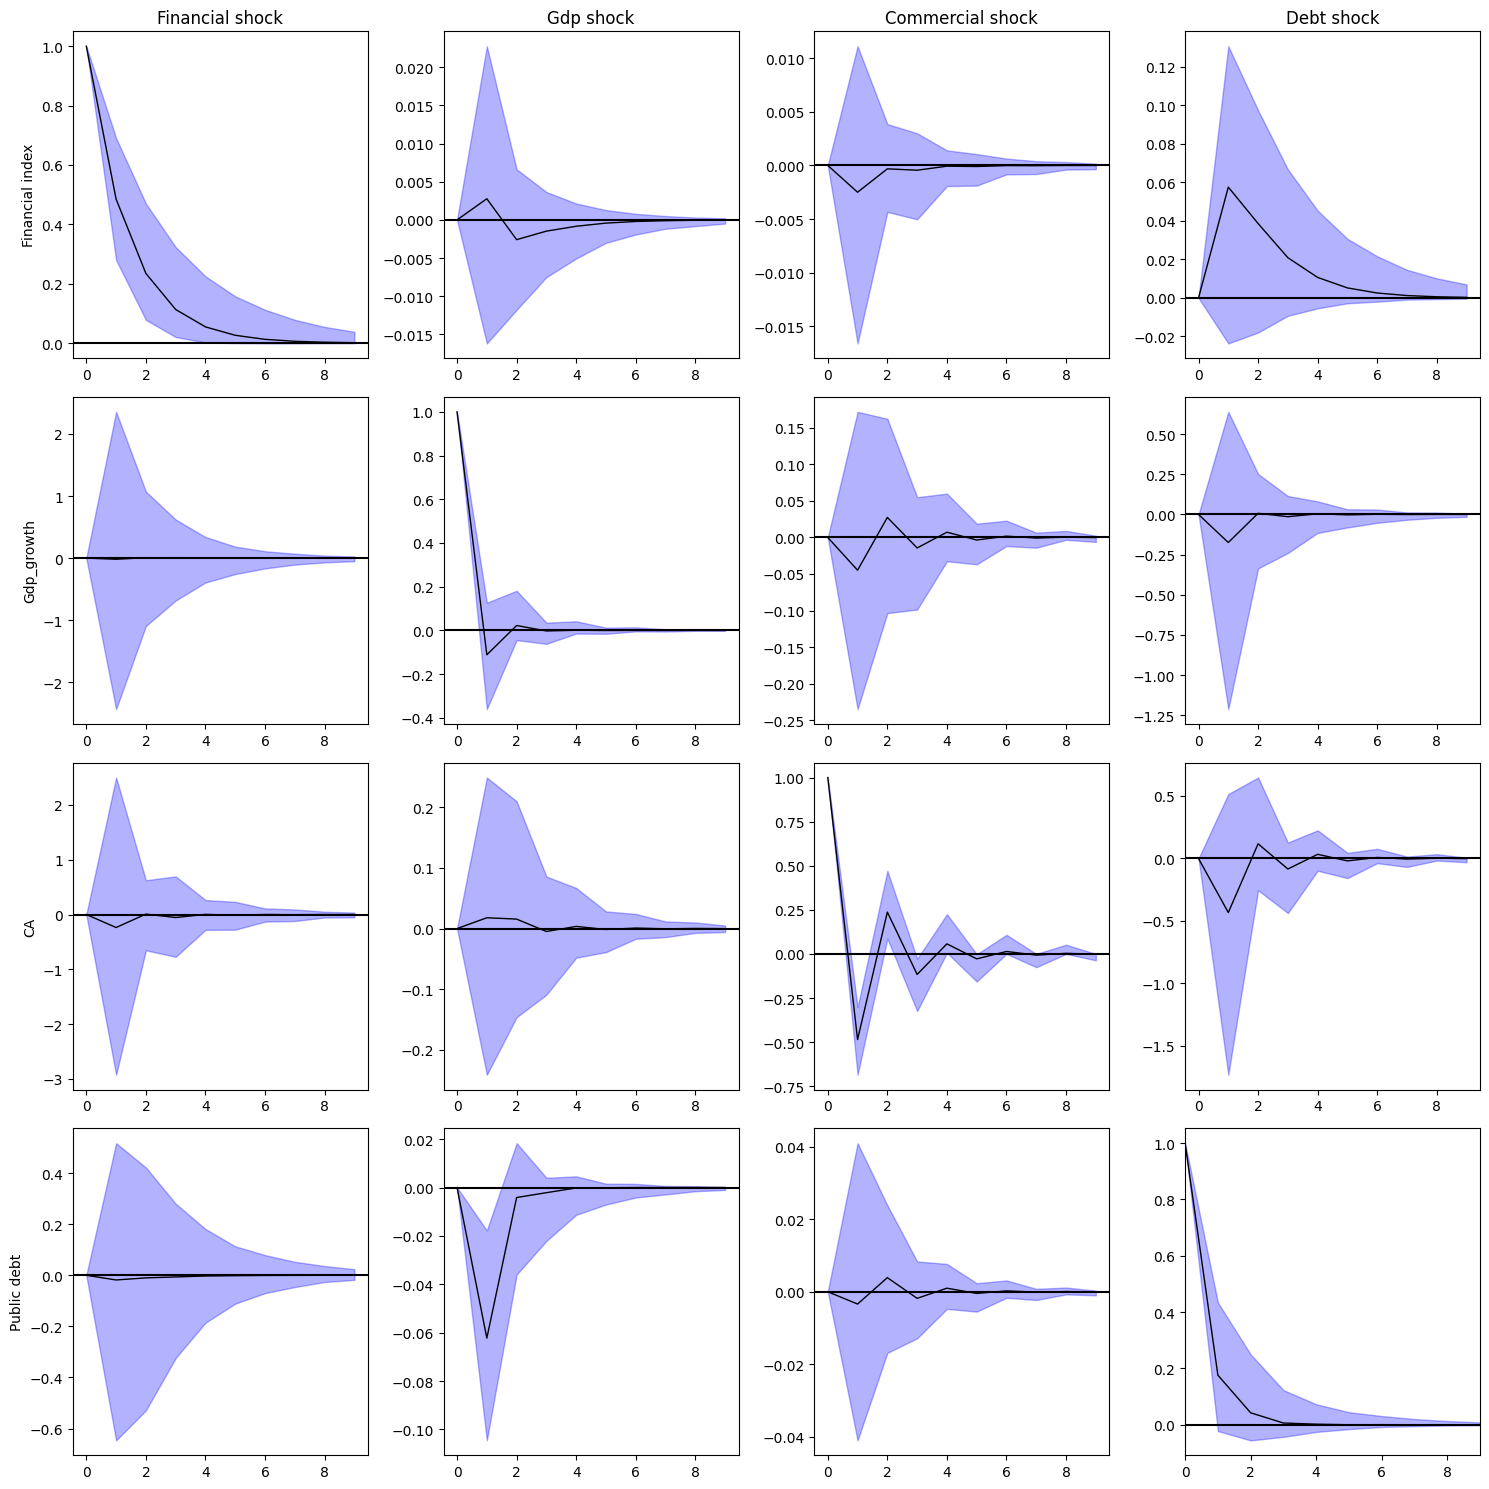

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


m = 4  # Considered Variable
p = 1  # Number of lags based on AIC criterion
c = 1  # Constant term
h = 10 # IRF horizon

T = len(gre)
Y = gre.iloc[p:, :]  # Adjust for lags

# Create lagged matrix
X_lagged = pd.DataFrame()
for col in gre.columns:
    for i in range(1, p+1):
        X_lagged[f'{col}_lag_{i}'] = gre[col].shift(i)
X_lagged = X_lagged.iloc[p:, :]
X_lagged = X_lagged[[col for lag in sorted(set(int(re.search(r'_lag_(\d+)$', col).group(1)) if re.search(r'_lag_(\d+)$', col) else 0 for col in X_lagged.columns)) for col in [x for x in X_lagged.columns if re.search(fr'_lag_{lag}$', x)]] + [x for x in X_lagged.columns if not re.search(r'_lag_\d+$', x)]]
X_lagged.insert(0, 'const', 1)

# Estimate VAR model
pi_hat = np.dot(np.dot(np.linalg.inv(np.dot(X_lagged.T, X_lagged)), X_lagged.T), Y)
Y_fit = np.dot(X_lagged, pi_hat)
err = Y - Y_fit

A_comp = np.block([
    [pi_hat[1:, :].T],
    [np.eye(m * p - m), np.zeros((m * p - m, m))]
])

PHI = np.zeros((m, m, h))
for j in range(h):
    PHI_comp = np.linalg.matrix_power(A_comp, j)
    PHI[:, :, j] = PHI_comp[:m, :m]

PHI_plot = np.reshape(np.transpose(PHI, (2, 0, 1)), (h, m*m))

VARnames = ['Financial index', 'Gdp_growth', 'CA', 'Public debt']
Shocknames = ['Financial shock', 'Gdp shock', 'Commercial shock', 'Debt shock']

ylab = 0

# Bootstrap simulation to compute confidence intervals
n_bootstrap = 1000
alpha = 0.05
bootstrap_phis = np.zeros((n_bootstrap, m, m, h))

for b in range(n_bootstrap):
    # Resample residuals
    resampled_err = err.sample(frac=1, replace=True).values
    Y_bootstrap = Y_fit + resampled_err

    # Re-estimate the VAR model
    pi_hat_bootstrap = np.dot(np.dot(np.linalg.inv(np.dot(X_lagged.T, X_lagged)), X_lagged.T), Y_bootstrap)
    A_comp_bootstrap = np.block([
        [pi_hat_bootstrap[1:, :].T],
        [np.eye(m * p - m), np.zeros((m * p - m, m))]
    ])

    for j in range(h):
        PHI_comp_bootstrap = np.linalg.matrix_power(A_comp_bootstrap, j)
        bootstrap_phis[b, :, :, j] = PHI_comp_bootstrap[:m, :m]

lower_bound = np.percentile(bootstrap_phis, alpha/2*100, axis=0)
upper_bound = np.percentile(bootstrap_phis, (1-alpha/2)*100, axis=0)

fig, axes = plt.subplots(m, m, figsize=(15, 15))
axes_flat = axes.flatten()
for k in range(m*m):
    ax = axes_flat[k]
    ax.plot(np.arange(h), PHI_plot[:, k], linewidth=1, color='k')
    lb = lower_bound[k // m, k % m, :]
    ub = upper_bound[k // m, k % m, :]
    ax.fill_between(np.arange(h), lb, ub, color='blue', alpha=0.3)
    ax.axhline(0, color='k', linestyle='-')
    if k < 4:
        ax.set_title(Shocknames[k])
    if k in [0, 4, 8, 12]:  # Corrected indices for labels
        ax.set_ylabel(VARnames[ylab])
        ylab += 1
ax.set_xlim([0, h-1])
plt.tight_layout()
plt.show()


In [9]:
coefficents = pd.DataFrame(pi_hat)
coefficents.columns = ['Financial index','Gdp growth','Current Account','Public Debt']
coefficents.index = ['Const.','Fi_l1','Gdp_l1','Ca_l1','Pd_l1']
coefficents=coefficents.transpose()
coefficents

,Const.,Fi_l1,Gdp_l1,Ca_l1,Pd_l1
Financial index,0.002465,0.485010,0.002774,-0.002500,0.057514
Gdp growth,0.004898,-0.018284,-0.111489,-0.044817,-0.174710
Current Account,0.012821,-0.237137,0.017841,-0.485632,-0.432791
Public Debt,0.000167,-0.018427,-0.062266,-0.003397,0.175900


In [10]:
sigma_hat = np.dot(err.T, err) / (T - p - 1)
X_lagged_inv = np.linalg.inv(np.dot(X_lagged.T, X_lagged))
var_cov_matrix = np.kron(sigma_hat, X_lagged_inv)
std_err = np.sqrt(np.diag(var_cov_matrix).reshape(pi_hat.shape))

# Create DataFrame for standard errors
std_err_df = pd.DataFrame(std_err, index=coefficents.columns, columns=[col + '_std' for col in coefficents.index])
std_err_df=std_err_df.transpose()

t_values = pi_hat / std_err
t_values_df = pd.DataFrame(t_values, index=coefficents.columns, columns=[col + '_t' for col in coefficents.index])

In [11]:
from scipy.stats import t
degrees_of_freedom = T - (m * p) - 1
p_values = 2 * (1 - t.cdf(np.abs(t_values), df=degrees_of_freedom))

# Create DataFrame for p-values
p_values_df = pd.DataFrame(p_values, index=coefficents.columns, columns=[col + '_p' for col in coefficents.index])
print("p-values DataFrame:")
p_values_df.transpose()

p-values DataFrame:


,Const.,Fi_l1,Gdp_l1,Ca_l1,Pd_l1
Financial index_p,0.807414,0.000000,0.976840,0.983711,8.354298e-01
Gdp growth_p,0.961767,0.881784,0.823509,0.655510,3.022735e-09
Current Account_p,0.183783,0.848632,0.890138,0.356398,0.000000e+00
Public Debt_p,0.983046,0.874402,0.961946,0.901311,1.173098e-01


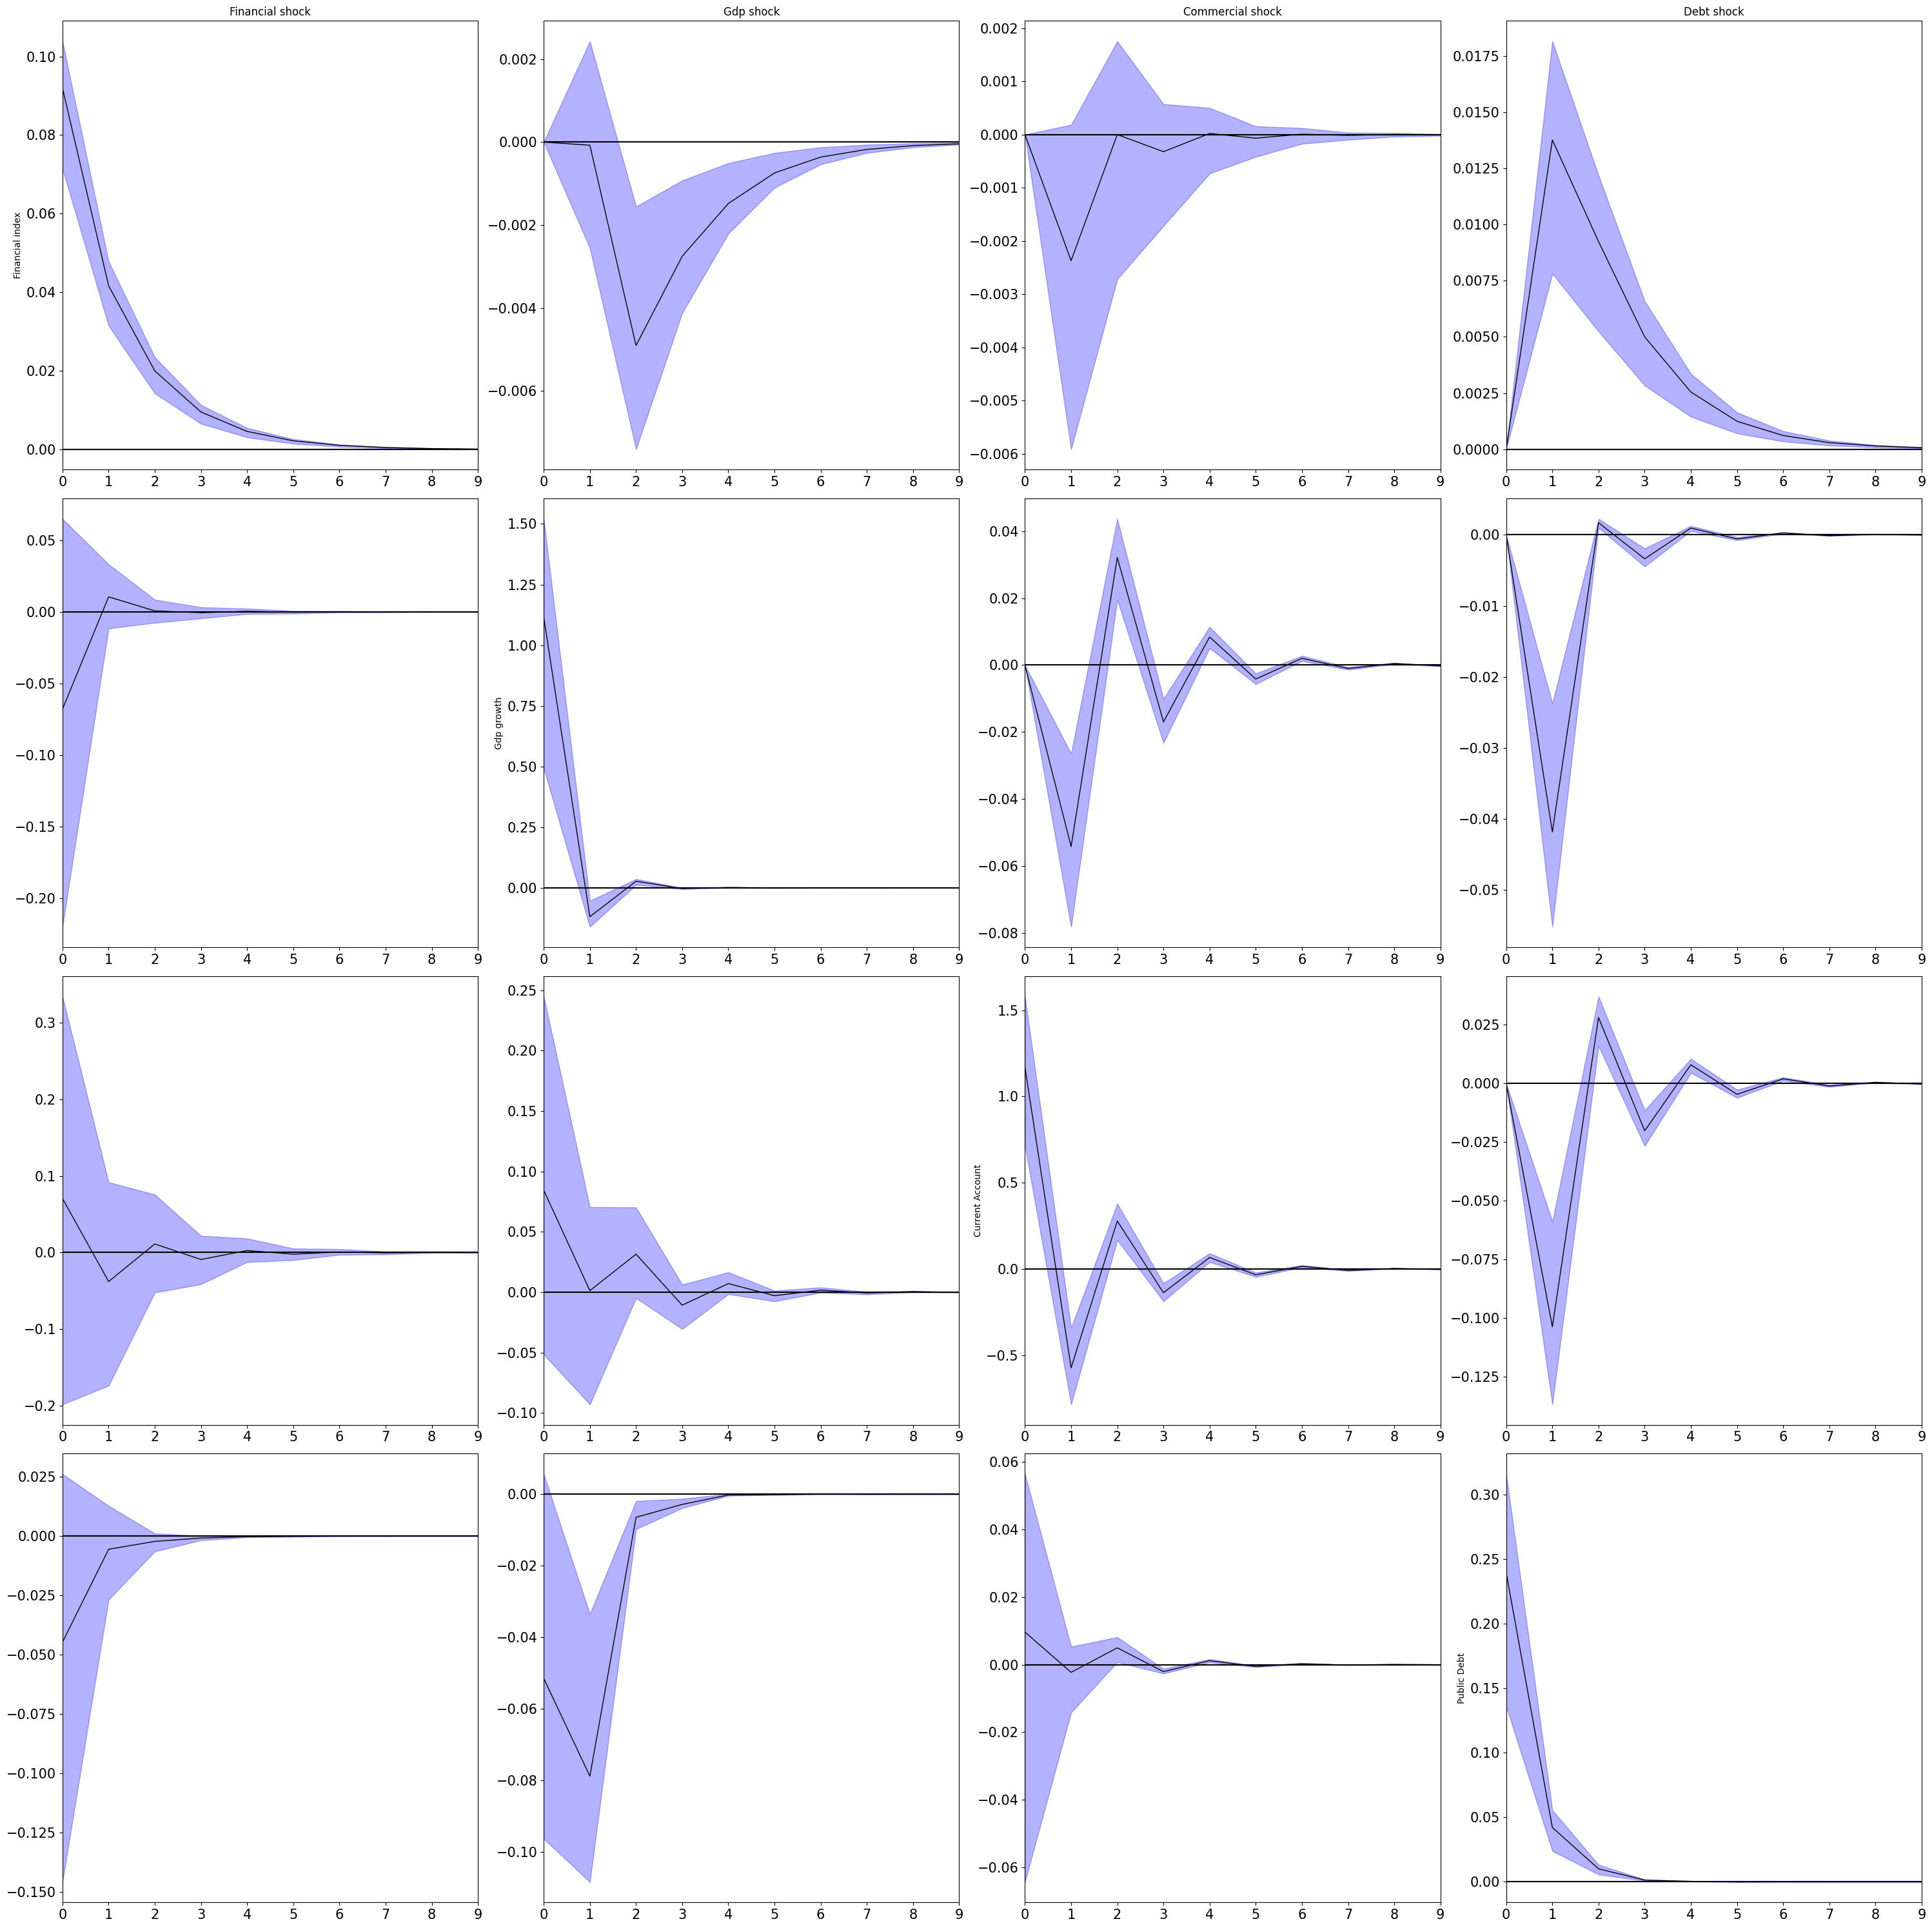

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Dati e parametri del modello VAR
T = len(gre) - m * p - m  # Lunghezza dei dati
omega = np.dot(err.T, err) / T  # Matrice di covarianza dei residui
P = np.linalg.cholesky(omega)  # Decomposizione di Cholesky di omega
PHI_SR = np.zeros((m, m, h))  # Matrice delle IRF

# Calcolo delle IRF
for i in range(h):
    PHI_SR[:, :, i] = np.dot(PHI[:, :, i], P)

# Plot delle IRF
PHI_SR_plot = np.reshape(np.transpose(PHI_SR, (2, 0, 1)), (h, m * m))

# Nomi delle variabili e degli shock
VARnames = ['Financial index', 'Gdp growth', 'Current Account', 'Public Debt']
Shocknames = ['Financial shock', 'Gdp shock', 'Commercial shock', 'Debt shock']

# Creazione della figura e dei subplot
fig, axes = plt.subplots(m, m, figsize=(30, 30))
axes_flat = axes.flatten()
ylab = 0

# Parametri del bootstrap
B = 1000  # Numero di bootstrap
percentile = 95  # Intervallo di confidenza del 95%

# Bootstrap per calcolare gli intervalli di confidenza
PHI_SR_bootstrap = np.zeros((B, h, m * m))

for b in range(B):
    # Resampling con ripetizione dei residui
    err_bootstrap = err.sample(n=T, replace=True, axis=0).to_numpy()
    
    # Calcolo della matrice di covarianza dei residui bootstrap
    omega_bootstrap = np.dot(err_bootstrap.T, err_bootstrap) / T
    
    # Decomposizione di Cholesky di omega_bootstrap
    P_bootstrap = np.linalg.cholesky(omega_bootstrap)
    
    # Calcolo delle IRF bootstrap
    PHI_SR_bootstrap_b = np.zeros((m, m, h))
    for i in range(h):
        PHI_SR_bootstrap_b[:, :, i] = np.dot(PHI[:, :, i], P_bootstrap)
    
    PHI_SR_bootstrap[b, :, :] = np.reshape(np.transpose(PHI_SR_bootstrap_b, (2, 0, 1)), (h, m * m))

# Calcolo degli intervalli di confidenza
lower_bound = np.percentile(PHI_SR_bootstrap, (100 - percentile) / 2, axis=0)
upper_bound = np.percentile(PHI_SR_bootstrap, 100 - (100 - percentile) / 2, axis=0)

# Grafico delle IRF con intervalli di confidenza
for k in range(m * m):
    ax = axes_flat[k]
    ax.plot(np.arange(h), PHI_SR_plot[:, k], linewidth=1, color='k', label='IRF')
    ax.fill_between(np.arange(h), lower_bound[:, k], upper_bound[:, k], color='blue', alpha=0.3, label='CI')
    ax.axhline(0, color='k', linestyle='-')
    
    if k < 4: 
        ax.set_title(Shocknames[k])
    if k in [0, 5, 10, 15]: 
        ax.set_ylabel(VARnames[ylab])
        ylab += 1

    ax.set_xlim([0, h - 1])
    ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()


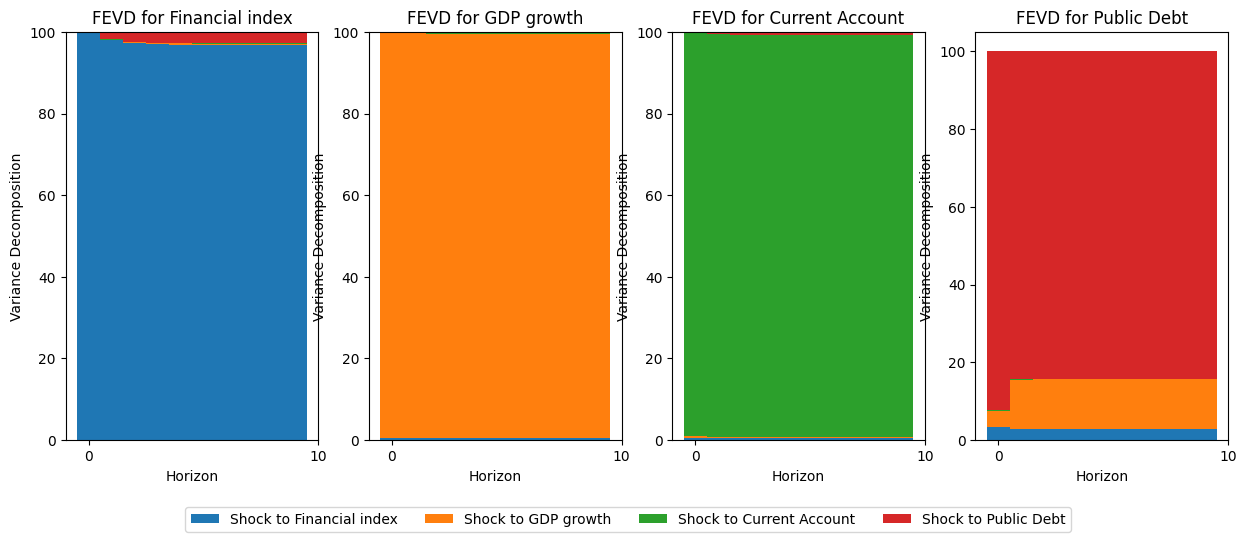

In [13]:
h = 10
MSE = np.zeros((m, m, h))
MSE_shock = np.zeros((m, m, h))
FEVD = np.zeros((h, m, m))

MSE[:, :, 0] = omega
for ii in range(m):
    for nn in range(1, h):
        MSE[:, :, nn] = MSE[:, :, nn - 1] + PHI[:, :, nn] @ omega @ PHI[:, :, nn].T
    MSE_shock[:, :, 0] = P[:, ii].reshape(-1, 1) @ P[:, ii].reshape(1, -1)

    for nn in range(1, h):
        MSE_shock[:, :, nn] = MSE_shock[:, :, nn - 1] + PHI[:, :, nn] @ MSE_shock[:, :, 0] @ PHI[:, :, nn].T
    FECD = MSE_shock[:, :, :] / MSE[:, :, :]

    for nn in range(h):
        for kk in range(m):
            FEVD[nn, ii, kk] = 100 * FECD[kk, kk, nn]

def plot_FEVD(FEVD_result, variable_names, horizon=40):
    """
    Plot FEVD results using stacked bar plots in subplots.
    FEVD_result: The FEVD matrix of shape (n, n, horizon)
    variable_names: List of names of the variables
    horizon: The number of periods ahead for the forecast
    """
    FEVD_result = FEVD_result.transpose((2, 1, 0))
    n = FEVD_result.shape[0]
    cols = 4
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))
    fig.subplots_adjust(bottom=0.2, hspace=0.4)

    if rows == 1:
        axes = axes.flatten()
    for i in range(n):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        bottom_values = np.zeros(horizon)
        for j in range(n):
            ax.bar(np.arange(horizon), FEVD_result[i, j, :], bottom=bottom_values, width=1, label=f"Shock to {variable_names[j]}")
            bottom_values += FEVD_result[i, j, :]
        ax.set_title(f"FEVD for {variable_names[i]}")
        ax.set_xlabel("Horizon")
        ax.set_ylabel("Variance Decomposition")
        ax.set_xticks(np.linspace(0, horizon, int(horizon / 10) + 1, endpoint=True))

    for i in range(n, rows * cols):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        ax.axis('off')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=len(variable_names))

variable_names = ['Financial index','GDP growth', 'Current Account', 'Public Debt']
plot_FEVD(FEVD, variable_names, h)
